In [8]:
!pip install pandas matplotlib seaborn plotly prophet fredapi

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from fredapi import Fred
import plotly.express as px
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

fred = Fred(api_key='e956a3dbccd7d4f90be734f8d55b1d07')

# Features and Target
series_ids = {
    'RSAFS': 'Retail Sales: All Food Services (Target)',
    'CPIAUCSL': 'Consumer Price Index',
    'UNRATE': 'Unemployment Rate',
    'FEDFUNDS': 'Federal Funds Rate',
    'PCE': 'Personal Consumption Expenditures',
    'DSPIC96': 'Real Disposable Personal Income'
}

# Data from FRED
data = pd.DataFrame()
for series_id in series_ids:
    data[series_id] = fred.get_series(series_id)

data.index = fred.get_series('RSAFS').index

data.dropna(inplace=True)

data.rename(columns=series_ids, inplace=True)

data.reset_index(inplace=True)
data.rename(columns={'index': 'ds', 'Retail Sales: All Food Services (Target)': 'y'}, inplace=True)

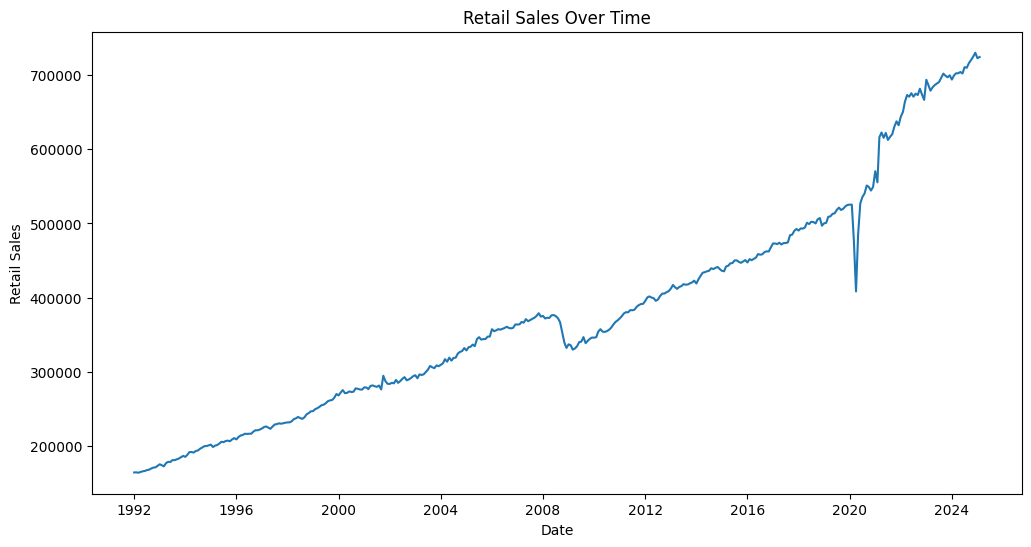

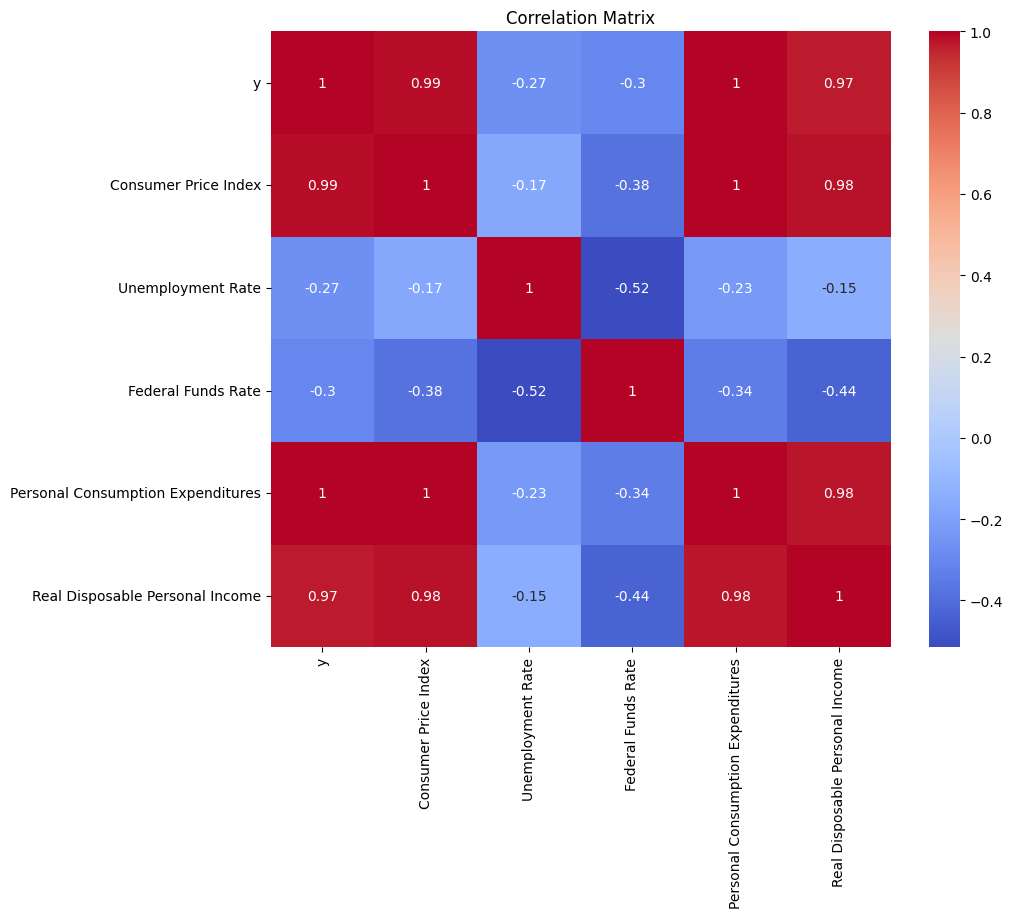

In [10]:
# --- EDA ---

# target variable
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='ds', y='y')
plt.title('Retail Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Retail Sales')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(data.drop(columns=['ds']).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [11]:
# --- Feature Engineering --- Most methods are no relevant

# lag features
data['lag_1'] = data['y'].shift(1)
data['lag_12'] = data['y'].shift(12)

data['rolling_mean_3'] = data['y'].rolling(window=3).mean()

data.dropna(inplace=True) # clean




INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpca2lv_qi/hk52_f9e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpca2lv_qi/1oi54p0r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18647', 'data', 'file=/tmp/tmpca2lv_qi/hk52_f9e.json', 'init=/tmp/tmpca2lv_qi/1oi54p0r.json', 'output', 'file=/tmp/tmpca2lv_qi/prophet_modelkju5n5o9/prophet_model-20250417172047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:20:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/

Model Evaluation Metrics:
(MAE): $73957.17
(RMSE): $89372.44
R² Score: -0.1290
MAPE): 11.20%


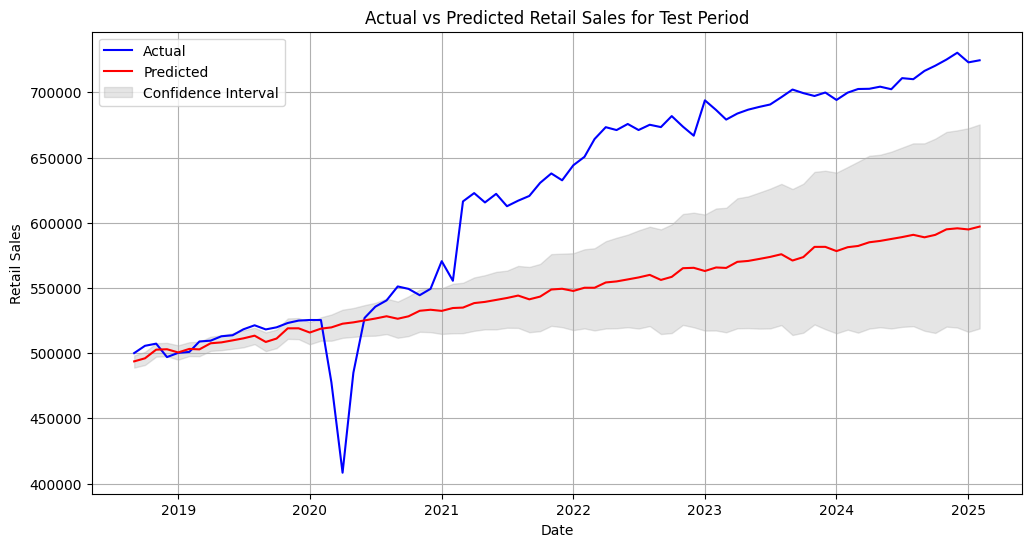

In [12]:

# --- Prophet ---

# Prepare data for Prophet
prophet_data = data[['ds', 'y']].copy()

train_size = int(len(prophet_data) * 0.8)
train_data = prophet_data[:train_size]
test_data = prophet_data[train_size:]

model = Prophet()
model.fit(train_data)

# future dataframe for the test period
future = model.make_future_dataframe(periods=len(test_data), freq='M')

# Forecast
forecast = model.predict(future)

predictions = forecast.tail(len(test_data))



# --- Model Evaluation ---

y_true = test_data['y'].values
y_pred = predictions['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Model Evaluation Metrics:")
print(f"(MAE): ${mae:.2f}")
print(f"(RMSE): ${rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE): {mape:.2f}%")

# Visualizations
plt.figure(figsize=(12, 6))
plt.plot(test_data['ds'], test_data['y'], 'b-', label='Actual')
plt.plot(test_data['ds'], predictions['yhat'], 'r-', label='Predicted')
plt.fill_between(test_data['ds'],
                 predictions['yhat_lower'],
                 predictions['yhat_upper'],
                 color='gray', alpha=0.2, label='Confidence Interval')
plt.title('Actual vs Predicted Retail Sales for Test Period')
plt.xlabel('Date')
plt.ylabel('Retail Sales')
plt.legend()
plt.grid(True)
plt.show()

SHAP is not the most suitable method to explain prophet (Next cell is the inherent one)

  0%|          | 0/386 [00:00<?, ?it/s]

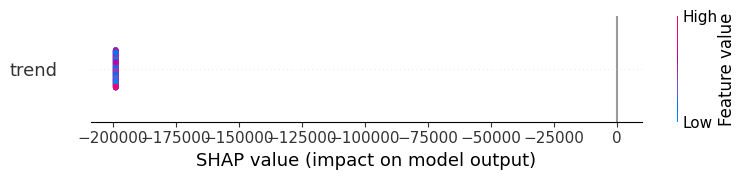

In [13]:
import shap
# --- SHAP Analysis ---

feature_cols = ['trend', 'seasonal', 'seasonal_yearly', 'seasonal_weekly', 'holidays']

existing_features = [col for col in feature_cols if col in forecast.columns]

X_shap = forecast[existing_features]

explainer = shap.KernelExplainer(lambda X: model.predict(forecast.iloc[:len(X)]).yhat.values, X_shap)
shap_values = explainer.shap_values(X_shap)

# Visualize
shap.summary_plot(shap_values, X_shap)

INFO:prophet:Making 46 forecasts with cutoffs between 1995-05-29 00:00:00 and 2017-08-01 00:00:00


  0%|          | 0/46 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 22.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpca2lv_qi/5fw46pba.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpca2lv_qi/6jyi4jvm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76654', 'data', 'file=/tmp/tmpca2lv_qi/5fw46pba.json', 'init=/tmp/tmpca2lv_qi/6jyi4jvm.json', 'output', 'file=/tmp/tmpca2lv_qi/prophet_modeln82s5au4/prophet_model-20250417172117.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:21:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:21:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpca2lv_qi/v47qtf97.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpca2lv_qi/yw1g9hl3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:ru


--- Cross-Validation Performance Metrics ---
MAE: $10931.37
RMSE: $16283.45
MAPE: 0.03%


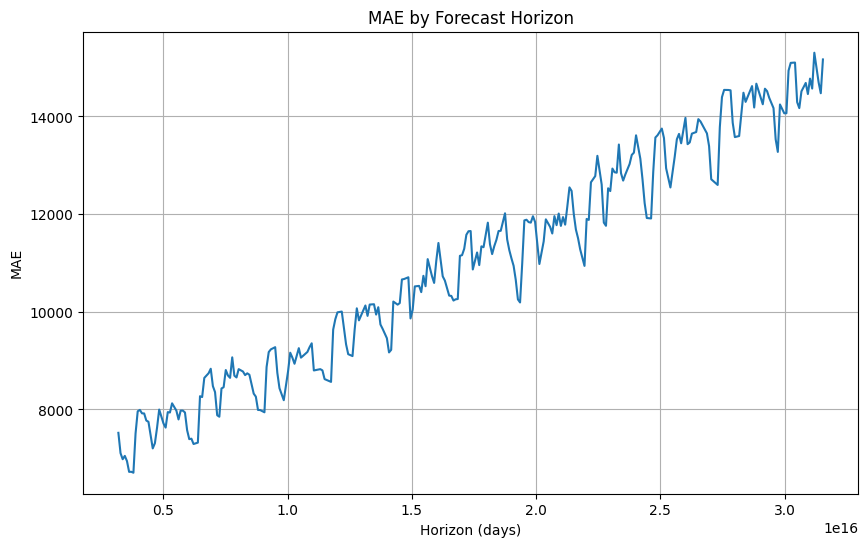

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


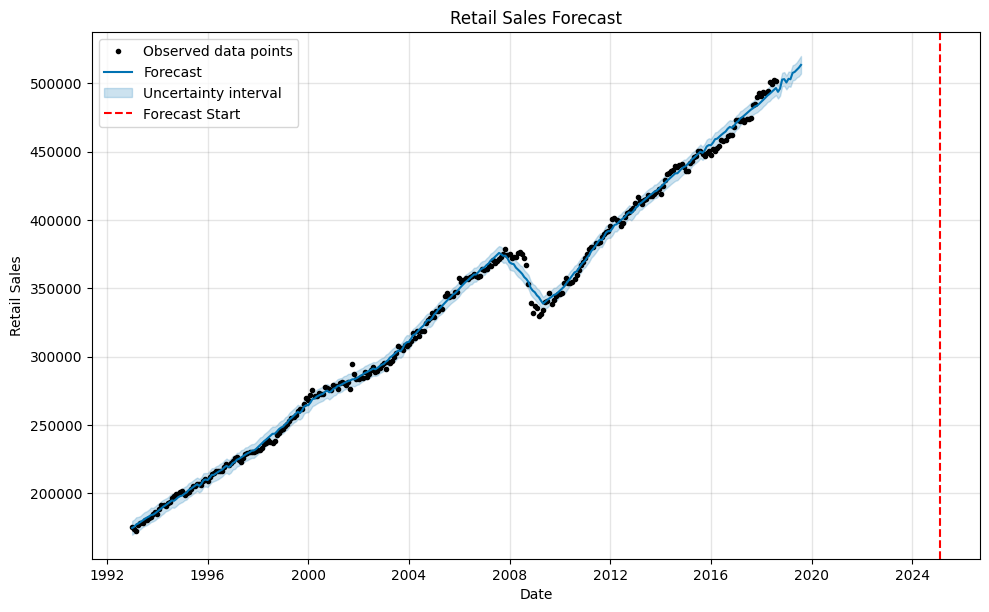

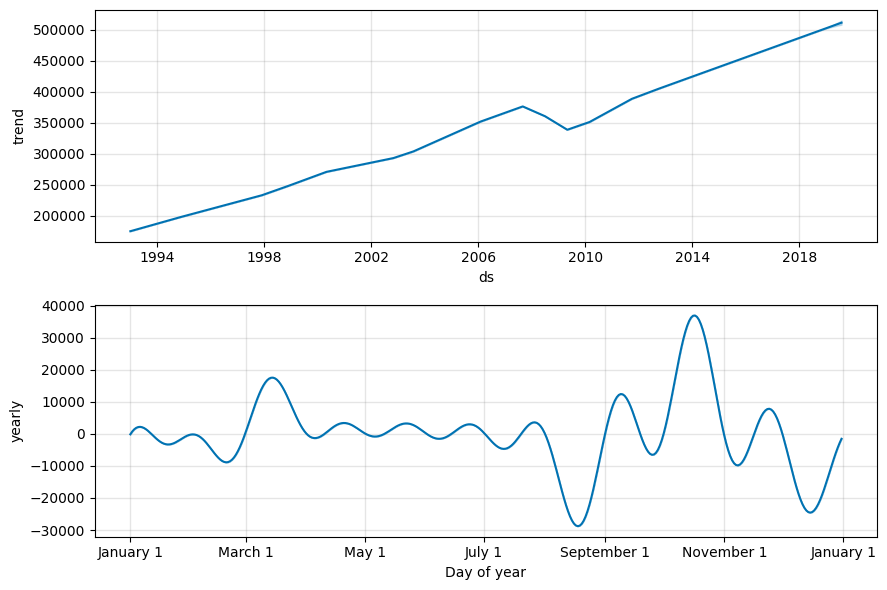

In [14]:
# --- Cross Validation ---
from prophet.diagnostics import cross_validation, performance_metrics

cv_results = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')

cv_metrics = performance_metrics(cv_results)
print("\n--- Cross-Validation Performance Metrics ---")
print(f"MAE: ${cv_metrics['mae'].mean():.2f}")
print(f"RMSE: ${cv_metrics['rmse'].mean():.2f}")
print(f"MAPE: {cv_metrics['mape'].mean():.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(cv_metrics['horizon'], cv_metrics['mae'])
plt.title('MAE by Forecast Horizon')
plt.xlabel('Horizon (days)')
plt.ylabel('MAE')
plt.grid(True)
plt.show()

# forecast for future periods (12 months ahead)
future_forecast = model.make_future_dataframe(periods=12, freq='M')
future_predictions = model.predict(future_forecast)

# full forecast included future periods
fig1 = model.plot(future_predictions)
plt.title('Retail Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Retail Sales')
plt.axvline(x=prophet_data['ds'].iloc[-1], color='r', linestyle='--', label='Forecast Start')
plt.legend()
plt.show()

fig2 = model.plot_components(future_predictions)
plt.show()

There are regular sales peaks around November, likely due to holiday shopping seasons (e.g., Black Friday, Christmas).

Sales dip around September, indicating a recurring slow period each year.

Some minor fluctuations are observed around March and July, suggesting smaller seasonal effects.